<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#評価するデータの取り出し" data-toc-modified-id="評価するデータの取り出し-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>評価するデータの取り出し</a></span><ul class="toc-item"><li><span><a href="#車の目視台数とパケット数の散布図" data-toc-modified-id="車の目視台数とパケット数の散布図-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>車の目視台数とパケット数の散布図</a></span></li></ul></li><li><span><a href="#Google-所要時間データの規格化" data-toc-modified-id="Google-所要時間データの規格化-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Google 所要時間データの規格化</a></span></li><li><span><a href="#回帰分析" data-toc-modified-id="回帰分析-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>回帰分析</a></span><ul class="toc-item"><li><span><a href="#データ作成-(numpyのndarrayに)" data-toc-modified-id="データ作成-(numpyのndarrayに)-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>データ作成 (numpyのndarrayに)</a></span></li><li><span><a href="#回帰分析" data-toc-modified-id="回帰分析-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>回帰分析</a></span></li><li><span><a href="#Wi-Fiパケットデータと回帰係数からの推定値の比較" data-toc-modified-id="Wi-Fiパケットデータと回帰係数からの推定値の比較-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Wi-Fiパケットデータと回帰係数からの推定値の比較</a></span></li><li><span><a href="#車のみ(歩行者数なし)の回帰" data-toc-modified-id="車のみ(歩行者数なし)の回帰-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>車のみ(歩行者数なし)の回帰</a></span></li></ul></li><li><span><a href="#サポートベクトル回帰-(SVM)" data-toc-modified-id="サポートベクトル回帰-(SVM)-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>サポートベクトル回帰 (SVM)</a></span></li><li><span><a href="#付録：練習" data-toc-modified-id="付録：練習-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>付録：練習</a></span></li></ul></div>

# 城東通りの統合データの統計的分析

## 評価するデータの取り出し


In [1]:
import pandas as pd

src_data = pd.read_csv("joto_data_summary.csv")
src_data.head()

Unnamed: 0      date  hour  fugetsu_east  muto_east  pedes_total_east  \
0           0  20191129    10          18.0       54.0              72.0   
1           1  20191129    11          29.0       74.0             103.0   
2           2  20191129    12          58.0      122.0             180.0   
3           3  20191129    13          34.0       97.0             131.0   
4           4  20191129    14          22.0       82.0             104.0   

   fugetsu_west  muto_west  pedes_total_west  wifi_east  wifi_west  car_east  \
0          43.0       73.0             116.0       38.0       32.0     446.0   
1          57.0       73.0             130.0       27.0       44.0     425.0   
2          47.0       71.0             118.0       20.0       34.0     405.0   
3          46.0       75.0             121.0       22.0       41.0     399.0   
4          61.0       51.0             112.0       23.0       38.0     450.0   

   car_west  west_bound  east_bound  
0       507  153.083333  117.833333  
1       569  177.333333  134.500000  
2       492  174.916667  122.250000  
3       510  181.333333  122.083333  
4       541  204.666667  129.083333

### 車の目視台数とパケット数の散布図

回帰分析の前に、実測データ関係を見てみる


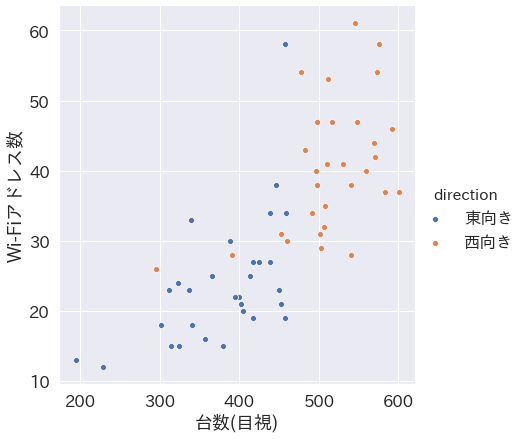

In [2]:
e_df = src_data.loc[:,['wifi_east','car_east']]
e_df.rename(columns={'wifi_east': 'Wi-Fiアドレス数', 'car_east': '台数(目視)'}, inplace=True)
e_df['direction'] = "東向き"
w_df = src_data.loc[:,['wifi_west','car_west']]
w_df.rename(columns={'wifi_west': 'Wi-Fiアドレス数', 'car_west': '台数(目視)'}, inplace=True)
w_df['direction'] = "西向き"
df4plot = pd.concat([e_df, w_df])

import seaborn as sns
sns.set(font_scale=1.5, font='IPAexGothic')
sns.pairplot(y_vars=['Wi-Fiアドレス数'], x_vars=['台数(目視)'], data=df4plot, hue='direction', height=6)

#src_data.plot(kind='scatter', x=['wifi_east','wifi_west'], y=['car_east','car_west'])

- 東向きでアドレス数が多いのは11/29(金)18時. ダン⇒風月堂の歩行者数が多いのだと考えられる
- 車の台数以上にアドレス数の多い4点は、金、土の17,18時　（渋滞によるものと考えられる）
- 日曜日の15時に西向きアドレス数が多いのは不明（歩行者？）
- 全体としてダン⇔風月堂間の「Wi-Fi流量」は車によるものである。

## Google 所要時間データの規格化

捕捉パケット数は「目視車台数ｘ渋滞率」に比例することを想定し、所要時間を最大値でわったデータを作成（「規格化」）

In [3]:
# 所要時間 (east_bound, west_bound)を最大値で規格化
src_data['norm_w_bound'] = src_data['west_bound'] / src_data['west_bound'].max()
src_data['norm_e_bound'] = src_data['east_bound'] / src_data['west_bound'].max()

# 規格化所要時間を車台数にかけて捕捉車台数（補正値）とする
src_data['scaled_car_east'] = src_data['car_east'] * src_data['norm_e_bound']
src_data['scaled_car_west'] = src_data['car_west'] * src_data['norm_w_bound']

src_data

Unnamed: 0      date  hour  fugetsu_east  muto_east  pedes_total_east  \
0            0  20191129    10          18.0       54.0              72.0   
1            1  20191129    11          29.0       74.0             103.0   
2            2  20191129    12          58.0      122.0             180.0   
3            3  20191129    13          34.0       97.0             131.0   
4            4  20191129    14          22.0       82.0             104.0   
5            5  20191129    15          38.0      104.0             142.0   
6            6  20191129    16          55.0      110.0             165.0   
7            7  20191129    17          81.0      191.0             272.0   
8            8  20191129    18          76.0      171.0             247.0   
9            9  20191129    19          75.0      138.0             213.0   
10          10  20191130    10          24.0       39.0              63.0   
11          11  20191130    11          20.0       86.0             106.0   
12          12  20191130    12          42.0       84.0             126.0   
13          13  20191130    13          36.0       63.0              99.0   
14          14  20191130    14          37.0       85.0             122.0   
15          15  20191130    15          51.0      104.0             155.0   
16          16  20191130    16          56.0       97.0             153.0   
17          17  20191130    17          52.0      117.0             169.0   
18          18  20191130    18          74.0      118.0             192.0   
19          19  20191130    19          61.0      126.0             187.0   
20          20  20191201    10          20.0       47.0              67.0   
21          21  20191201    11          23.0       62.0              85.0   
22          22  20191201    12          21.0       90.0             111.0   
23          23  20191201    13          37.0       71.0             108.0   
24          24  20191201    14          25.0       68.0              93.0   
25          25  20191201    15          34.0       89.0             123.0   
26          26  20191201    16          44.0       90.0             134.0   
27          27  20191201    17          44.0       92.0             136.0   
28          28  20191201    18          37.0       83.0             120.0   
29          29  20191201    19          29.0      111.0             140.0   

    fugetsu_west  muto_west  pedes_total_west  wifi_east  wifi_west  car_east  \
0           43.0       73.0             116.0       38.0       32.0     446.0   
1           57.0       73.0             130.0       27.0       44.0     425.0   
2           47.0       71.0             118.0       20.0       34.0     405.0   
3           46.0       75.0             121.0       22.0       41.0     399.0   
4           61.0       51.0             112.0       23.0       38.0     450.0   
5           39.0       52.0              91.0       34.0       37.0     439.0   
6           59.0       57.0             116.0       22.0       41.0     395.0   
7           66.0       88.0             154.0       34.0       47.0     459.0   
8          132.0       70.0             202.0       58.0       61.0     457.0   
9          117.0       50.0             167.0       33.0       54.0     339.0   
10          53.0       62.0             115.0       16.0       43.0     357.0   
11          37.0       61.0              98.0       25.0       42.0     413.0   
12          51.0       87.0             138.0       21.0       46.0     402.0   
13          45.0       70.0             115.0       19.0       47.0     417.0   
14          68.0       76.0             144.0       19.0       37.0     458.0   
15          53.0       65.0             118.0       21.0       28.0     453.0   
16          52.0       73.0             125.0       27.0       40.0     439.0   
17         111.0       91.0             202.0       30.0       58.0     388.0   
18         160.0       96.0             256.0       27.0       54.0     417.0

## 回帰分析

### データ作成 (numpyのndarrayに)



In [4]:
# 機械学習ライブラリsklearnでは、データはnumpyなので
# np.ndarray配列として作成

import numpy as np

# target （目的変数）Wi-Fi east & west
target_east = src_data['wifi_east'].values
target_west = src_data['wifi_west'].values
# type(target_east) # typeで確かめ

# (1) features (説明変数) pedes_total_*　（歩行量調査データ）, car_* （車の目視データ）
features_east = src_data[['pedes_total_east', 'car_east']].values
features_west = src_data[['pedes_total_west', 'car_west']].values

# (2) features (説明変数) pedes_total_*　（歩行量調査データ）, scaled_car_* （車の目視データを所要時間で補正したもの）
features_east_sc = src_data[['pedes_total_east', 'scaled_car_east']].values
features_west_sc = src_data[['pedes_total_west', 'scaled_car_west']].values

features_east[0:5,:] # 最初の5行をみてみる

array([[ 72., 446.],
       [103., 425.],
       [180., 405.],
       [131., 399.],
       [104., 450.]])

### 回帰分析

- 切片なし
- 渋滞係数なしの分析 (歩行量調査データと車通行量目視データ)


In [5]:
# ライブラリをロード
from sklearn.linear_model import LinearRegression
# 線形回帰機
regression = LinearRegression(fit_intercept=False)

# 渋滞係数なし
e_model = regression.fit(features_east, target_east)
print(e_model.coef_)
#print(e_model.intercept_)
w_model = regression.fit(features_west, target_west)
print(w_model.coef_)
#print(w_model.intercept_)

east_coef = e_model.coef_
west_coef = w_model.coef_

# 渋滞係数あり
s_e_model = regression.fit(features_east_sc, target_east)
print(s_e_model.coef_)
s_w_model = regression.fit(features_west_sc, target_west)
print(s_w_model.coef_)
s_east_coef = s_e_model.coef_
s_west_coef = s_w_model.coef_
s_e_model.predict(features_east_sc)

[0.0673778  0.03933883]
[0.16056571 0.03818761]
[0.06932099 0.07488025]
[0.18389072 0.04328399]


array([23.3090323 , 29.89266354, 42.58632496, 33.42240557, 30.25377753,
       36.99060642, 38.43332875, 59.48659661, 55.48286697, 47.36323995,
       19.54215301, 28.79652643, 31.96337895, 27.02017113, 32.37960772,
       38.19477969, 37.87092089, 39.31665752, 44.95423886, 42.26020549,
       18.84948786, 22.12078713, 27.27127273, 26.50789061, 25.41376817,
       30.32352394, 32.40956341, 32.21225805, 26.82363879, 29.70784413])

### Wi-Fiパケットデータと回帰係数からの推定値の比較



In [6]:
# 歩行量、車量に回帰係数をかけてWi-Fi推定値を算出

estimate_e = features_east[:,0]* east_coef[0] + features_east[:,1]* east_coef[1]
estimate_w = features_west[:,0]* west_coef[0] + features_west[:,1]* west_coef[1]

estimate_s_e = features_east_sc[:,0]* s_east_coef[0] + features_east_sc[:,1]* s_east_coef[1]
estimate_s_w = features_west_sc[:,0]* s_west_coef[0] + features_west_sc[:,1]* s_west_coef[1]


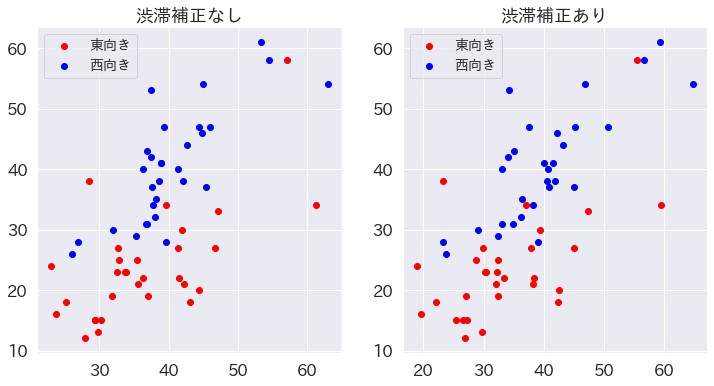

In [7]:
# 描画
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1,2,1)
ax1.scatter(estimate_e, src_data['wifi_east'].values, c = 'red', label='東向き')
ax1.scatter(estimate_w, src_data['wifi_west'].values, c = 'blue', label='西向き')
ax1.legend(fontsize=14)
ax1.set_title('渋滞補正なし')

ax2 = fig.add_subplot(1,2,2)
ax2.scatter(estimate_s_e, src_data['wifi_east'].values, c = 'red', label='東向き')
ax2.scatter(estimate_s_w, src_data['wifi_west'].values, c = 'blue', label='西向き')
ax2.legend(fontsize=14)
ax2.set_title('渋滞補正あり')

fig.show()


歩行者数は、風月堂と武藤呉服店の値であるため、ダン⇔風月堂の流れとは異なる可能性が大きい。

南北の通り（春日モールなど）との交差点で人の出入りがあるため。


### 車のみ(歩行者数なし)の回帰


In [8]:

# (1) features (説明変数) car_* （車の目視データ）
features_east = src_data[['car_east']].values
features_west = src_data[['car_west']].values

# (2) features (説明変数) scaled_car_* （車の目視データを所要時間で補正したもの）
features_east_sc = src_data[['scaled_car_east']].values
features_west_sc = src_data[['scaled_car_west']].values


In [129]:
# 線形回帰機
regression = LinearRegression(fit_intercept=False) # 切片の有無　(外れ値があるためか切片を入れると推定値がずれる)

# 渋滞係数なし
e_model = regression.fit(features_east, target_east)
print(e_model.coef_)
print(e_model.intercept_)
w_model = regression.fit(features_west, target_west)
print(w_model.coef_)
print(w_model.intercept_)

east_coef = e_model.coef_
west_coef = w_model.coef_

# 渋滞係数あり
s_e_model = regression.fit(features_east_sc, target_east)
print(s_e_model.coef_)
print(s_e_model.intercept_)
s_w_model = regression.fit(features_west_sc, target_west)
print(s_w_model.coef_)
print(s_w_model.intercept_)
s_east_coef = s_e_model.coef_
s_west_coef = s_w_model.coef_

[0.06336476]
0.0
[0.07848053]
0.0
[0.12234921]
0.0
[0.10503199]
0.0


In [130]:
s_e_model.predict(features_east_sc) # 下のように計算しなくても、predict()で推定値を得られる

array([24.43297552, 26.57569018, 23.01851109, 22.64657928, 27.00573633,
       26.39662051, 19.63431904, 22.9756227 , 24.4158899 , 19.8846369 ,
       19.30837505, 22.57715201, 21.33726308, 21.39026336, 24.13217566,
       23.51771332, 23.62429503, 19.99288455, 23.40973687, 19.1035801 ,
       15.84266794, 15.74867768, 16.64487837, 16.13114755, 20.16955216,
       18.69670219, 18.85016281, 17.47893545, 11.54263255,  9.61687811])

In [131]:
# 歩行量、車量に回帰係数をかけてWi-Fi推定値を算出

estimate_e = features_east[:,0]* east_coef[0] + e_model.intercept_
estimate_w = features_west[:,0]* west_coef[0] + w_model.intercept_

estimate_s_e = features_east_sc[:,0]* s_east_coef[0] + s_e_model.intercept_
estimate_s_w = features_west_sc[:,0]* s_west_coef[0] + s_w_model.intercept_


In [132]:
estimate_s_e

array([24.43297552, 26.57569018, 23.01851109, 22.64657928, 27.00573633,
       26.39662051, 19.63431904, 22.9756227 , 24.4158899 , 19.8846369 ,
       19.30837505, 22.57715201, 21.33726308, 21.39026336, 24.13217566,
       23.51771332, 23.62429503, 19.99288455, 23.40973687, 19.1035801 ,
       15.84266794, 15.74867768, 16.64487837, 16.13114755, 20.16955216,
       18.69670219, 18.85016281, 17.47893545, 11.54263255,  9.61687811])

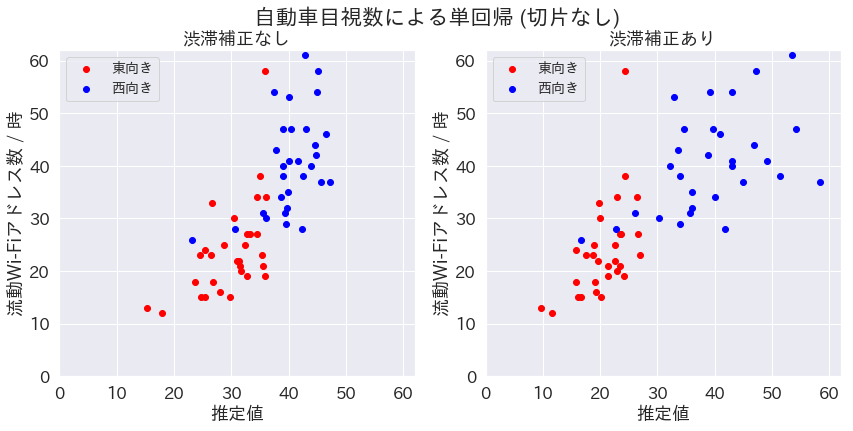

In [133]:
# 描画
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(1,2,1)
ax1.scatter(estimate_e, target_east, c = 'red', label='東向き')
ax1.scatter(estimate_w, target_west, c = 'blue', label='西向き')
ax1.legend(fontsize=14)
ax1.set_title('渋滞補正なし')
ax1.set_xlabel('推定値')
ax1.set_ylabel('流動Wi-Fiアドレス数 / 時')

ax2 = fig.add_subplot(1,2,2)
ax2.scatter(estimate_s_e, target_east, c = 'red', label='東向き')
ax2.scatter(estimate_s_w, target_west, c = 'blue', label='西向き')
ax2.legend(fontsize=14)
ax2.set_title('渋滞補正あり')
ax2.set_xlabel('推定値')
ax2.set_ylabel('流動Wi-Fiアドレス数 / 時')
ax1.set_xlim([0,62])
ax1.set_ylim([0,62])
ax2.set_xlim([0,62])
ax2.set_ylim([0,62])
fig.suptitle("自動車目視数による単回帰 (切片なし)")
fig.show()

In [134]:
src_data['estimated_e'] = estimate_s_e
src_data['estimated_w'] = estimate_s_w

In [135]:
src_data

Unnamed: 0      date  hour  fugetsu_east  muto_east  pedes_total_east  \
0            0  20191129    10          18.0       54.0              72.0   
1            1  20191129    11          29.0       74.0             103.0   
2            2  20191129    12          58.0      122.0             180.0   
3            3  20191129    13          34.0       97.0             131.0   
4            4  20191129    14          22.0       82.0             104.0   
5            5  20191129    15          38.0      104.0             142.0   
6            6  20191129    16          55.0      110.0             165.0   
7            7  20191129    17          81.0      191.0             272.0   
8            8  20191129    18          76.0      171.0             247.0   
9            9  20191129    19          75.0      138.0             213.0   
10          10  20191130    10          24.0       39.0              63.0   
11          11  20191130    11          20.0       86.0             106.0   
12          12  20191130    12          42.0       84.0             126.0   
13          13  20191130    13          36.0       63.0              99.0   
14          14  20191130    14          37.0       85.0             122.0   
15          15  20191130    15          51.0      104.0             155.0   
16          16  20191130    16          56.0       97.0             153.0   
17          17  20191130    17          52.0      117.0             169.0   
18          18  20191130    18          74.0      118.0             192.0   
19          19  20191130    19          61.0      126.0             187.0   
20          20  20191201    10          20.0       47.0              67.0   
21          21  20191201    11          23.0       62.0              85.0   
22          22  20191201    12          21.0       90.0             111.0   
23          23  20191201    13          37.0       71.0             108.0   
24          24  20191201    14          25.0       68.0              93.0   
25          25  20191201    15          34.0       89.0             123.0   
26          26  20191201    16          44.0       90.0             134.0   
27          27  20191201    17          44.0       92.0             136.0   
28          28  20191201    18          37.0       83.0             120.0   
29          29  20191201    19          29.0      111.0             140.0   

    fugetsu_west  muto_west  pedes_total_west  wifi_east  ...  car_east  \
0           43.0       73.0             116.0       38.0  ...     446.0   
1           57.0       73.0             130.0       27.0  ...     425.0   
2           47.0       71.0             118.0       20.0  ...     405.0   
3           46.0       75.0             121.0       22.0  ...     399.0   
4           61.0       51.0             112.0       23.0  ...     450.0   
5           39.0       52.0              91.0       34.0  ...     439.0   
6           59.0       57.0             116.0       22.0  ...     395.0   
7           66.0       88.0             154.0       34.0  ...     459.0   
8          132.0       70.0             202.0       58.0  ...     457.0   
9          117.0       50.0             167.0       33.0  ...     339.0   
10          53.0       62.0             115.0       16.0  ...     357.0   
11          37.0       61.0              98.0       25.0  ...     413.0   
12          51.0       87.0             138.0       21.0  ...     402.0   
13          45.0       70.0             115.0       19.0  ...     417.0   
14          68.0       76.0             144.0       19.0  ...     458.0   
15          53.0       65.0             118.0       21.0  ...     453.0   
16          52.0       73.0             125.0       27.0  ...     439.0   
17         111.0       91.0             202.0       30.0  ...     388.0   
18         160.0       96.0             256.0       27.0  ...     417.0   
19         109.0       59.0             168.0       18.0  ...     341.0   
20          44.0       77.0             1

Text(0.5, 0.98, '自動車目視数によるWi-Fiパケット流量推定 (LM 切片なし)')

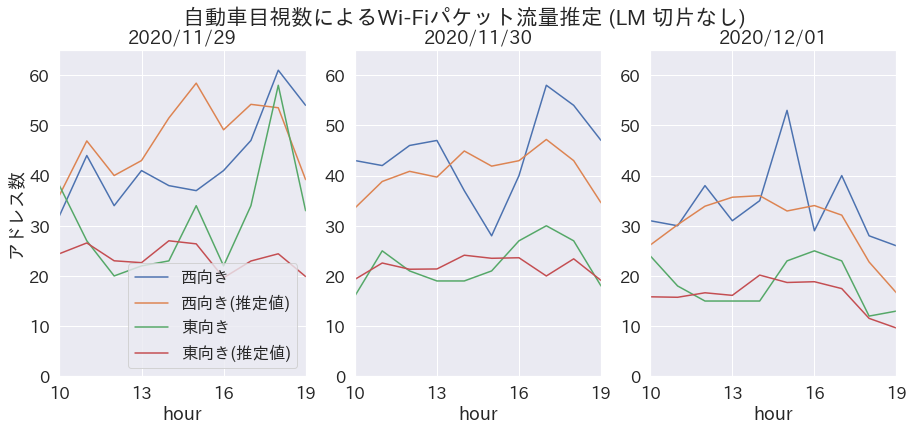

In [139]:
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
a = src_data.groupby(['date'])

a.get_group((20191129)).plot(x='hour', y='wifi_west', label='西向き', ax=axes[0])
a.get_group((20191129)).plot(x='hour', y='estimated_w', label='西向き(推定値)', ax=axes[0])
a.get_group((20191129)).plot(x='hour', y='wifi_east', label='東向き', ax=axes[0])
a.get_group((20191129)).plot(x='hour', y='estimated_e', label='東向き(推定値)', ax=axes[0])

a.get_group((20191130)).plot(x='hour', y='wifi_west', label='西向き', ax=axes[1])
a.get_group((20191130)).plot(x='hour', y='estimated_w', label='西向き(推定値)', ax=axes[1])
a.get_group((20191130)).plot(x='hour', y='wifi_east', label='東向き', ax=axes[1])
a.get_group((20191130)).plot(x='hour', y='estimated_e', label='東向き(推定値)', ax=axes[1])

a.get_group((20191201)).plot(x='hour', y='wifi_west', label='西向き', ax=axes[2])
a.get_group((20191201)).plot(x='hour', y='estimated_w', label='西向き(推定値)', ax=axes[2])
a.get_group((20191201)).plot(x='hour', y='wifi_east', label='東向き', ax=axes[2])
a.get_group((20191201)).plot(x='hour', y='estimated_e', label='東向き(推定値)', ax=axes[2])

axes[0].set_ylim([0,65])
axes[1].set_ylim([0,65])
axes[2].set_ylim([0,65])
axes[0].set_xticks(np.linspace(10, 19, 4))
axes[1].set_xticks(np.linspace(10, 19, 4))
axes[2].set_xticks(np.linspace(10, 19, 4))
axes[0].set_ylabel("アドレス数")
#axes[1].set_ylabel("アドレス数")
#axes[2].set_ylabel("アドレス数")
axes[0].set_title("2020/11/29")
axes[1].set_title("2020/11/30")
axes[2].set_title("2020/12/01")

axes[1].legend().set_visible(False)
axes[2].legend().set_visible(False)
fig.suptitle("自動車目視数によるWi-Fiパケット流量推定 (LM 切片なし)")

## サポートベクトル回帰 (SVM)



Text(0.5, 0.98, '自動車目視数によるWi-Fiパケット流量推定 (SVM)')

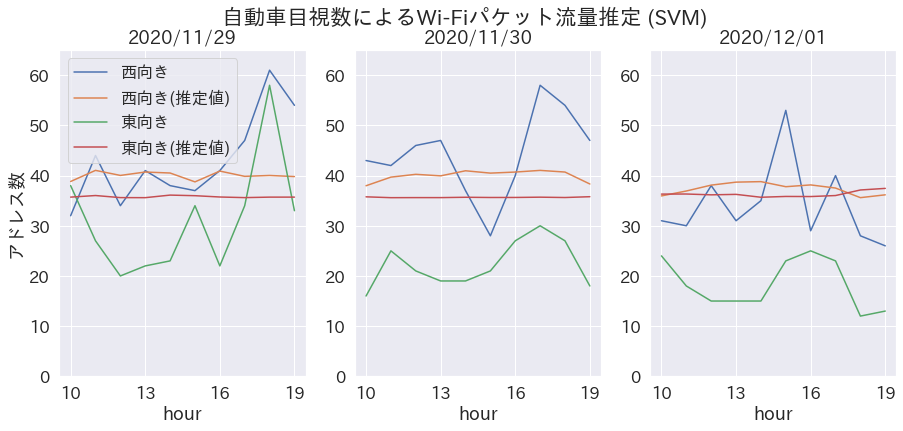

In [10]:
from sklearn import svm

# 学習を行う
svr = svm.SVR(kernel='rbf', gamma='scale')
# 渋滞係数あり
s_e_model = svr.fit(features_east_sc, target_east)
s_w_model = svr.fit(features_west_sc, target_west)

# 推定値をもとのデータフレームの列に追加
src_data['estimated_e'] = s_e_model.predict(features_east_sc)
src_data['estimated_w'] = s_w_model.predict(features_west_sc)

# 回帰曲線を描く (LMの時と同じ)
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
a = src_data.groupby(['date'])

a.get_group((20191129)).plot(x='hour', y='wifi_west', label='西向き', ax=axes[0])
a.get_group((20191129)).plot(x='hour', y='estimated_w', label='西向き(推定値)', ax=axes[0])
a.get_group((20191129)).plot(x='hour', y='wifi_east', label='東向き', ax=axes[0])
a.get_group((20191129)).plot(x='hour', y='estimated_e', label='東向き(推定値)', ax=axes[0])

a.get_group((20191130)).plot(x='hour', y='wifi_west', label='西向き', ax=axes[1])
a.get_group((20191130)).plot(x='hour', y='estimated_w', label='西向き(推定値)', ax=axes[1])
a.get_group((20191130)).plot(x='hour', y='wifi_east', label='東向き', ax=axes[1])
a.get_group((20191130)).plot(x='hour', y='estimated_e', label='東向き(推定値)', ax=axes[1])

a.get_group((20191201)).plot(x='hour', y='wifi_west', label='西向き', ax=axes[2])
a.get_group((20191201)).plot(x='hour', y='estimated_w', label='西向き(推定値)', ax=axes[2])
a.get_group((20191201)).plot(x='hour', y='wifi_east', label='東向き', ax=axes[2])
a.get_group((20191201)).plot(x='hour', y='estimated_e', label='東向き(推定値)', ax=axes[2])

axes[0].set_ylim([0,65])
axes[1].set_ylim([0,65])
axes[2].set_ylim([0,65])
axes[0].set_xticks(np.linspace(10, 19, 4))
axes[1].set_xticks(np.linspace(10, 19, 4))
axes[2].set_xticks(np.linspace(10, 19, 4))
axes[0].set_ylabel("アドレス数")
#axes[1].set_ylabel("アドレス数")
#axes[2].set_ylabel("アドレス数")
axes[0].set_title("2020/11/29")
axes[1].set_title("2020/11/30")
axes[2].set_title("2020/12/01")

axes[1].legend().set_visible(False)
axes[2].legend().set_visible(False)
fig.suptitle("自動車目視数によるWi-Fiパケット流量推定 (SVM)")

変化なしの結果になった。


## 付録：練習

In [2]:
# 練習 python機械学習クックブック　１３．２
# -*- coding: utf-8 -*-

# ライブラリをロード
from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_boston
from sklearn.preprocessing import PolynomialFeatures

# データをロード with only two features
boston = load_boston()
features = boston.data[:,0:2]
target = boston.target
# boston {'data': [[]], 'target': [], 'feature_names': []}
# features は dataの最初の2列

# 交互作用の項を作成
interaction = PolynomialFeatures(
    degree=3, include_bias=False, interaction_only=True)
features_interaction = interaction.fit_transform(features)

# 線形回帰器を作成
regression = LinearRegression()

# 線形回帰器を訓練
model = regression.fit(features_interaction, target)

##########

# 最初の観測値の特徴量の値を表示
features[0]

##########

# ライブラリをロード
import numpy as np

# 個々の観測値に対して、最初の特徴量値と2つ目の特徴量値を掛け合わせる
interaction_term = np.multiply(features[:, 0], features[:, 1])

##########

# 最初の観測値の交互作用項を表示
interaction_term[0]

##########

# 最初の観測値の値を表示
features_interaction[0]


array([6.3200e-03, 1.8000e+01, 1.1376e-01])

In [10]:
model.coef_

array([-0.33715159,  0.08155747,  0.80662   ])

In [11]:
model.intercept_

22.07715825584366

Googleの道路状況がかなり即時的に表示されていることを示す面白い実験例

https://www.youtube.com/watch?v=k5eL_al_m7Q
